In [16]:
import pandas as pd
import matplotlib.pyplot as plt

https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR5jxk4FClm9GBFvCklV4Ga5SRwON3ajfqLdOMjFqN1uereEEduffCtjEbkjJg_aem_YUf8t7fIjwbCWiHS_vrVcg

In [17]:
nodes_df = pd.read_csv('nodes.csv')

In [18]:
edges_df = pd.read_csv('edges.csv')

In [19]:
nodes_df

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"['nordic house', 'russelater']",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"['christlicher rap', 'german hip hop']","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,[],['de (1)']
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"['dancehall', 'lovers rock', 'modern reggae', ...","['at (1)', 'de (1)']"
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"['classic swedish pop', 'norrbotten indie', 's...",['se (6)']
...,...,...,...,...,...,...
156417,2ces6d2YsQP1RpGMYpdFy8,David Urwitz,5470.0,29,['classic swedish pop'],NaN
156418,6AeznZajNbXUulT7W4tK5l,Darmiko,2022.0,23,[],NaN
156419,3GEijIjrgb4lPe9WtURBzz,Katriell,268.0,0,[],NaN
156420,0ldQL0icSoMz9OOZcWG8Zt,Yung Fresh,181.0,19,[],NaN


In [20]:
edges_df

,id_0,id_1
0,76M2Ekj8bG8W7X2nbx2CpF,7sfl4Xt5KmfyDs2T3SVSMK
1,0hk4xVujcyOr6USD95wcWb,7Do8se3ZoaVqUt3woqqSrD
2,38jpuy3yt3QIxQ8Fn1HTeJ,4csQIMQm6vI2A2SCVDuM2z
3,6PvcxssrQ0QaJVaBWHD07l,6UCQYrcJ6wab6gnQ89OJFh
4,2R1QrQqWuw3IjoP5dXRFjt,4mk1ScvOUkuQzzCZpT6bc0
...,...,...
300381,0PK0Dx3s9et0Uf4XbdFpiW,6SmpksRq3jxeDZ7roKDb6F
300382,5hqRsNHDZH1jHzI9LgxFRZ,7KYseTkErcYMRvcIqacxUq
300383,0wjb0t7aYMuIwyuXnPOilh,2p1fiYHYiXz9qi0JJyxBzN
300384,3ciRvbBIVz9fBoPbtSYq4x,5einkgXXrjhfYCyac1FANB


In [21]:
import networkx as nx

In [22]:


nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

# Create a new graph
G = nx.Graph()

# Add nodes to the graph
# Each node has the artist name as a label and spotify_id as the node identifier
for _, row in nodes_df.iterrows():
    # Convert potential NaN values to appropriate types
    followers = row['followers'] if not pd.isna(row['followers']) else 0
    popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
    genres = row['genres'] if not pd.isna(row['genres']) else []
    chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []
    
    G.add_node(row['spotify_id'], name=row['name'], followers=followers, 
                popularity=popularity, genres=genres, chart_hits=chart_hits)

# Add edges between artists
for _, row in edges_df.iterrows():
    id_0 = row['id_0']
    id_1 = row['id_1']
    # Only add edge if both nodes exist in the graph
    if id_0 in G.nodes and id_1 in G.nodes:
        G.add_edge(id_0, id_1)



In [23]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G)}")

Number of nodes: 156316
Number of edges: 300322
Network density: 2.4581764569116915e-05


In [24]:
# Print some of the nodes with their names
print("\nSample of artists in the network:")
for i, (node_id, node_data) in enumerate(G.nodes(data=True)):
    if i >= 5:  # Print only first 5 nodes
        break
    print(f"{node_id}: {node_data.get('name', 'N/A')}")

# Print some of the edges
print("\nSample of connections between artists:")
for i, (source, target) in enumerate(list(G.edges())[:100]):
    source_name = G.nodes[source].get('name', 'N/A')
    target_name = G.nodes[target].get('name', 'N/A')
    print(f"{source_name} is connected to {target_name}")


Sample of artists in the network:
48WvrUGoijadXXCsGocwM4: Byklubben
4lDiJcOJ2GLCK6p9q5BgfK: Kontra K
652XIvIBNGg3C0KIGEJWit: Maxim
3dXC1YPbnQPsfHPVkm1ipj: Christopher Martin
74terC9ol9zMo8rfzhSOiG: Jakob Hellman

Sample of connections between artists:
Byklubben is connected to Lauren Flynn
Byklubben is connected to Thomas Gregersen
Kontra K is connected to DILOMAN
Kontra K is connected to Bonez MC
Kontra K is connected to BACI
Kontra K is connected to AK AUSSERKONTROLLE
Kontra K is connected to Luciano
Kontra K is connected to Samra
Kontra K is connected to Rico
Kontra K is connected to R3HAB
Kontra K is connected to Blokkmonsta
Kontra K is connected to SDP
Kontra K is connected to DieserMorten
Kontra K is connected to Kurdo
Kontra K is connected to Vollbluthustler
Kontra K is connected to Xavier Naidoo
Kontra K is connected to BTNG
Kontra K is connected to Jah Khalib
Kontra K is connected to Haftbefehl
Kontra K is connected to Nisse
Kontra K is connected to Cardi B
Kontra K is connec

In [ ]:
largest_cc_artist_network = max(nx.connected_components(G), key=len)
largest_cc_artist_network_subgraph = G.subgraph(largest_cc_artist_network).copy()

print(f"Original network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Largest Connected Component: {largest_cc_artist_network_subgraph.number_of_nodes()} nodes, {largest_cc_artist_network_subgraph.number_of_edges()} edges")

Original network: 156316 nodes, 300322 edges
Largest Connected Component: 148337 nodes, 296706 edges


In [27]:
# Get all connected components sorted by size (descending)
connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

# Pick the second largest component
second_largest_cc = connected_components[1]
second_largest_cc_subgraph = G.subgraph(second_largest_cc).copy()

print(f"Original network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Second Largest Connected Component: {second_largest_cc_subgraph.number_of_nodes()} nodes, {second_largest_cc_subgraph.number_of_edges()} edges")


Original network: 156316 nodes, 300322 edges
Second Largest Connected Component: 66 nodes, 65 edges


TypeError: 'NoneType' object is not subscriptable

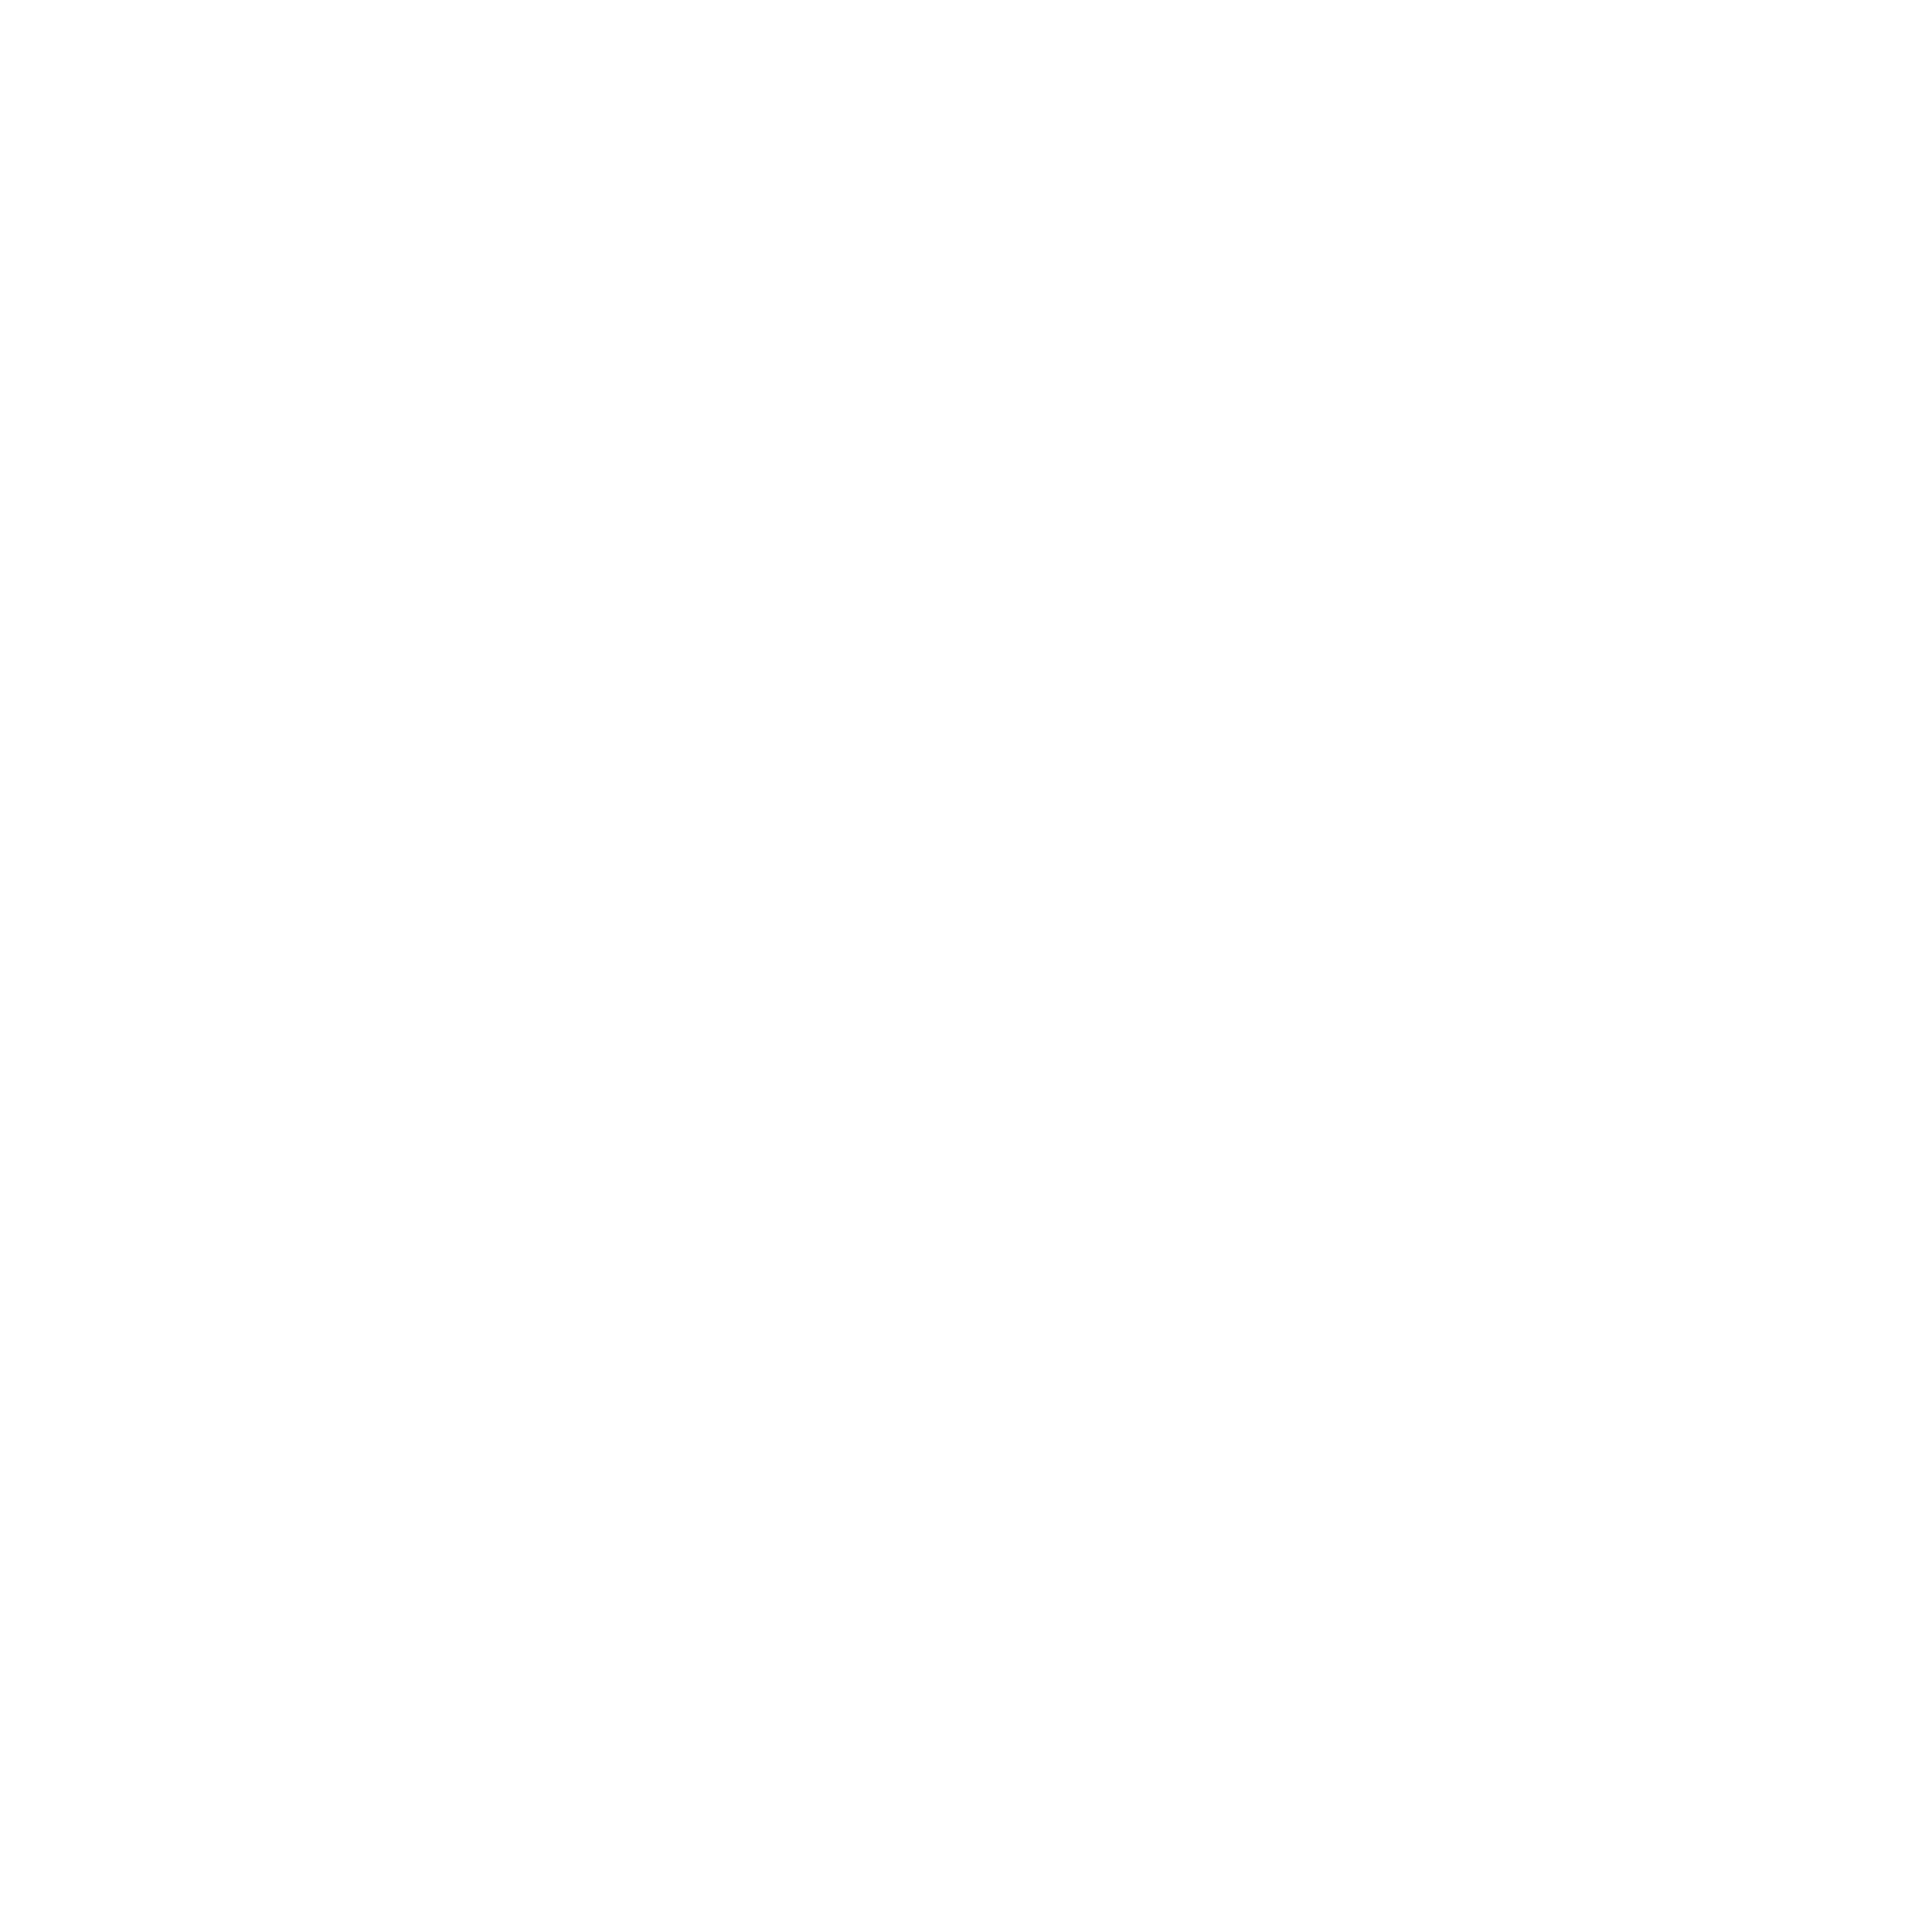

In [ ]:
import netwulf as nw


# config_random_network = {
#     # Input/output
#     'zoom': 0.7,
#     # Physics
#     'node_charge': -90,
#     'node_gravity': 0.27,
#     'link_distance': 15,
#     'link_distance_variation': 0,
#     'node_collision': True,
#     'wiggle_nodes': False,
#     'freeze_nodes': False,
#     # Nodes
#     'node_fill_color': '#e57468',
#     'node_stroke_color': '#ea5545',
#     'node_label_color': '#000000',
#     'display_node_labels': False,
#     'scale_node_size_by_strength': False,
#     'node_size': 5,
#     'node_stroke_width': 1,
#     'node_size_variation': 0.5,
#     # Links
#     'link_color': '#2e2e2e',
#     'link_width': 0.3,
#     'link_alpha': 0.79,
#     'link_width_variation': 0.5,
#     # Thresholding
#     'display_singleton_nodes': True,
#     'min_link_weight_percentile': 0,
#     'max_link_weight_percentile': 1
# }

network, config = nw.visualize(second_largest_cc_subgraph, plot_in_cell_below=False)

fig, ax = nw.draw_netwulf(network, figsize=20)
plt.savefig("second_largest.pdf")


Number of nodes in subset: 1000
Number of edges in subset: 195
Network density of subset: 0.000390


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12302 (\N{LEFT WHITE CORNER BRACKET}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12518 (\N{KATAKANA LETTER YU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 12303 (\

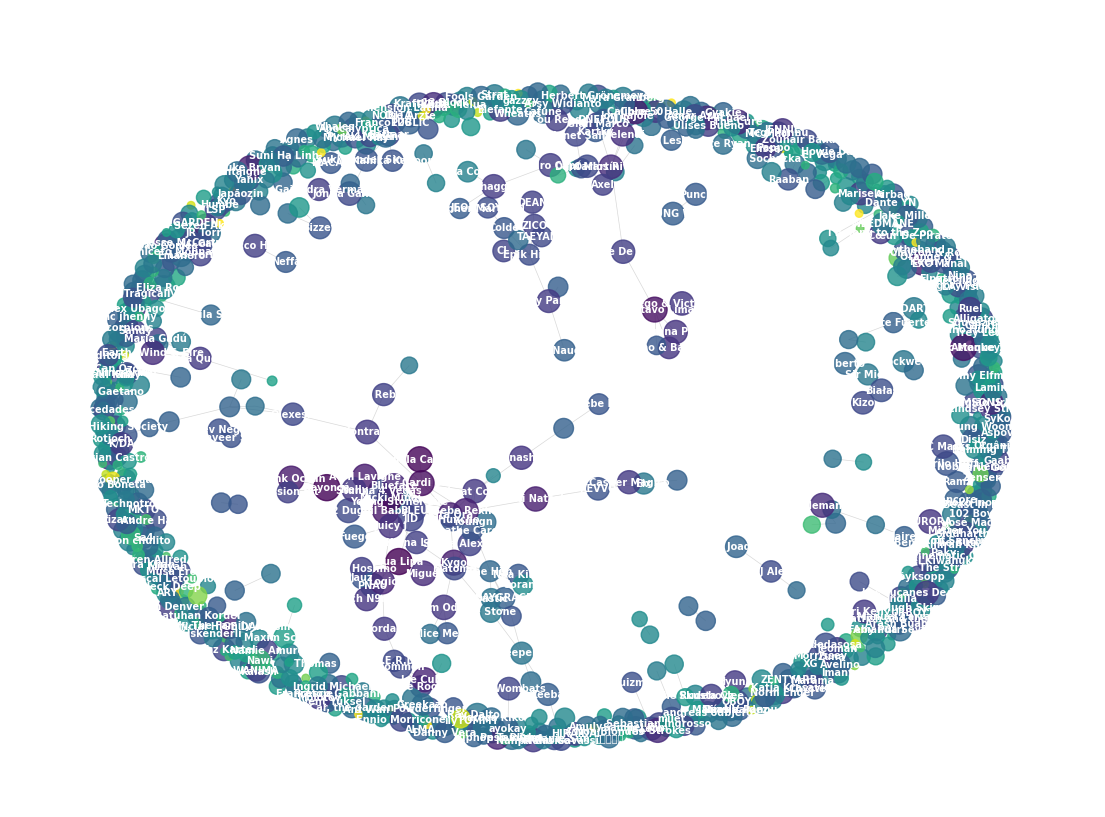

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def create_spotify_graph(nodes_file, edges_file, max_nodes=None):
    # Read CSV files and handle NaN values
    nodes_df = pd.read_csv(nodes_file)
    edges_df = pd.read_csv(edges_file)
    
    # Drop rows with NaN values in critical columns
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])
    
    # Limit to max_nodes if specified
    if max_nodes is not None and max_nodes < len(nodes_df):
        nodes_df = nodes_df.head(max_nodes)
    
    # Create a new graph
    G = nx.Graph()
    
    # Add nodes to the graph
    for _, row in nodes_df.iterrows():
        # Convert potential NaN values to appropriate types
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres'] if not pd.isna(row['genres']) else []
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []
        
        G.add_node(row['spotify_id'], name=row['name'], followers=followers, 
                  popularity=popularity, genres=genres, chart_hits=chart_hits)
    
    # Keep track of valid node ids
    valid_node_ids = set(G.nodes())
    
    # Add edges between artists (only if both nodes are in our subset)
    for _, row in edges_df.iterrows():
        id_0 = row['id_0']
        id_1 = row['id_1']
        # Only add edge if both nodes exist in the graph
        if id_0 in valid_node_ids and id_1 in valid_node_ids:
            G.add_edge(id_0, id_1)
    
    return G

def visualize_network(G, title="Spotify Artists Network (Subset)"):
    # Set up the figure with a black background
    plt.figure(figsize=(14, 10))
    plt.title(title, fontsize=18, color='white')
    plt.axis('off')
    
    # Use spring layout for force-directed placement
    layout = nx.spring_layout(G, k=0.2, iterations=100)  # Adjusted parameters for better spacing
    
    # Extract popularity values for node sizing
    popularity_values = [G.nodes[node].get('popularity', 30) for node in G.nodes()]
    # Convert to node sizes - scale popularity to make it visible
    node_sizes = [max(30, p * 4) for p in popularity_values]
    
    # Extract follower count for node color intensity
    follower_values = [np.log1p(G.nodes[node].get('followers', 1000)) for node in G.nodes()]
    
    # Create a colormap for the nodes based on follower count
    norm = plt.Normalize(min(follower_values), max(follower_values))
    color_map = plt.cm.viridis_r
    
    # Draw the network
    # Draw edges
    nx.draw_networkx_edges(G, layout, alpha=0.3, width=0.5, edge_color='gray')
    
    # Draw nodes
    nx.draw_networkx_nodes(G, layout, 
                         node_size=node_sizes,
                         node_color=follower_values, 
                         cmap=color_map,
                         alpha=0.8)
    
    # For a subset visualization, we can show more labels
    # Select nodes with higher popularity for labeling (adjusted threshold)
    high_popularity_nodes = {node: G.nodes[node]['name'] for node in G.nodes() 
                           if G.nodes[node].get('popularity', 0) > 50}
    
    nx.draw_networkx_labels(G, layout, 
                          labels=high_popularity_nodes, 
                          font_size=7, 
                          font_color='white',
                          font_weight='bold')
    
    # Add a colorbar to show the follower scale
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Log(Followers)', shrink=0.75, pad=0.05)
    
    # Set background color to black
    plt.gca().set_facecolor('black')
    plt.gcf().set_facecolor('black')
    
    # Add legend explaining the visualization
    plt.figtext(0.12, 0.01, "Node size: Artist popularity", 
              color='white', fontsize=10)
    plt.figtext(0.42, 0.01, "Node color: Number of followers (log scale)", 
              color='white', fontsize=10)
    plt.figtext(0.78, 0.01, "Labels: Artists with popularity > 50", 
              color='white', fontsize=10)
    
    # Calculate network metrics for this subset
    density = nx.density(G)
    average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    
    # Add network metrics to the plot
    plt.figtext(0.02, 0.98, f"Network Density: {density:.4f}", 
              color='white', fontsize=10)
    plt.figtext(0.02, 0.96, f"Avg. Connections per Artist: {average_degree:.2f}", 
              color='white', fontsize=10)
    plt.figtext(0.02, 0.94, f"Artists in Subset: {G.number_of_nodes()}", 
              color='white', fontsize=10)
    plt.figtext(0.02, 0.92, f"Connections in Subset: {G.number_of_edges()}", 
              color='white', fontsize=10)
    
    # Adjust layout to make room for the colorbar
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('spotify_network_subset.png', dpi=300, bbox_inches='tight', facecolor='black')
    
    plt.show()

# Create a graph with the first 1000 nodes
G = create_spotify_graph('nodes.csv', 'edges.csv', max_nodes=1000)

# Print some basic metrics about the subset graph
print(f"Number of nodes in subset: {G.number_of_nodes()}")
print(f"Number of edges in subset: {G.number_of_edges()}")
print(f"Network density of subset: {nx.density(G):.6f}")

# Visualize the network subset
visualize_network(G, title="Spotify Artists Network (First 1000 Artists)")

# Find connected components
connected_components = list(nx.connected_components(G))
print(f"Number of connected components: {len(connected_components)}")
print(f"Size of largest connected component: {len(max(connected_components, key=len))}")

# If there are too many isolated nodes, we might want to visualize only the connected ones
if len(connected_components) > 1:
    largest_cc = max(connected_components, key=len)
    G_largest_cc = G.subgraph(largest_cc)
    print(f"Visualizing largest connected component with {G_largest_cc.number_of_nodes()} nodes")
    visualize_network(G_largest_cc, title="Largest Connected Component (Subset)")